In [1]:
import os, os.path
import glob
import pickle
import numpy
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate
#import matplotlib
#matplotlib.use('PDF')
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
import pal5_util
from gd1_util import R0, V0
import custom_stripping_df
import seaborn as sns
import astropy.units as u
from galpy import potential
%pylab inline
#from matplotlib import cm, pyplot
#from matplotlib.ticker import FuncFormatter, NullFormatter

def galcencyl_to_lbd(R,phi,Z,degree=True):
    xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
    lbd=bovy_coords.XYZ_to_lbd(xyz[0],xyz[1],xyz[2],degree=degree)
    return lbd[0], lbd[1], lbd[2]

Populating the interactive namespace from numpy and matplotlib


In [3]:
ro,vo= 8., 220.

rolr=0.9
barphi=25 #degrees


from galpy.potential import DehnenBarPotential
dp= DehnenBarPotential(rolr=rolr,barphi=barphi)

MWPotential2014bar= [MWPotential2014[0],MWPotential2014[1],MWPotential2014[2],dp]

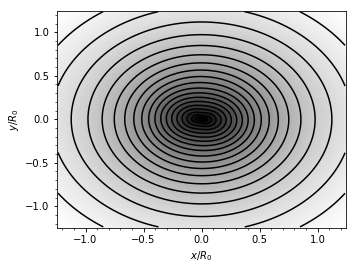

In [4]:
#plot potential contours

potential.plotPotentials(MWPotential2014bar,rmin=-10.*u.kpc,rmax=10.*u.kpc,zmin=-10.*u.kpc,zmax=10.*u.kpc,nrs=100,nzs=100,xy=True)



In [15]:
print dp.OmegaP()*(vo/ro)  #km/s/kpc
print dp._rb*ro # bar radius in kpc


52.1615960918
3.37412988073


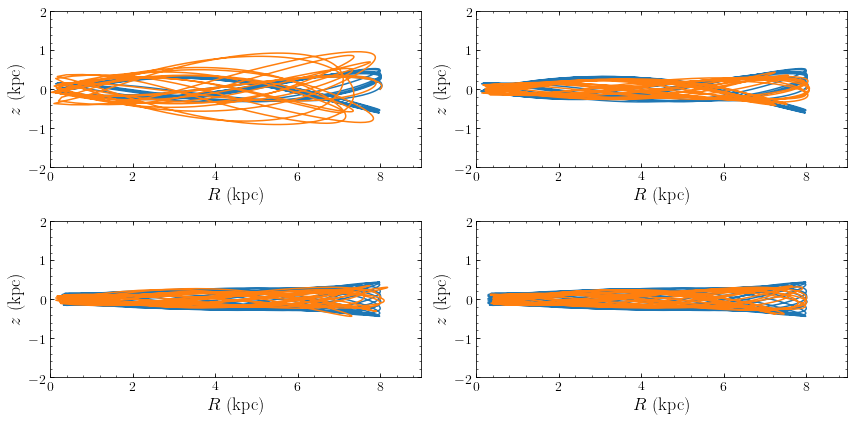

In [6]:
#plot orbits

ts= numpy.linspace(0,1.,1001)*u.Gyr
def plot_orbit_comparison(o):
    o.integrate(ts,potential.MWPotential2014)
    o.plot(yrange=[-2.,2.],xrange=[0.,9.],gcf=True)
    o.integrate(ts,MWPotential2014bar)
    o.plot(overplot=True,gcf=True)
    return None

def plot_orbit_comparisonXY(o):
    o.integrate(ts,potential.MWPotential2014)
    o.plot(d1='x',d2='y',xrange=[-10.,10.],yrange=[-10.,10.],gcf=True)
    o.integrate(ts,MWPotential2014bar)
    o.plot(d1='x',d2='y',overplot=True,gcf=True)
    return None


#vxvv=[R,vR,vT,z,vz,phi]

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(12,6)
subplot(2,2,1)
o= Orbit([1.,0.1,0.03,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparison(o)
subplot(2,2,2)
o= Orbit([1.,0.1,-0.03,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparison(o)
subplot(2,2,3)
o= Orbit([1.,0.05,0.07,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparison(o)
subplot(2,2,4)
o= Orbit([1.,0.05,-0.07,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparison(o)
tight_layout()


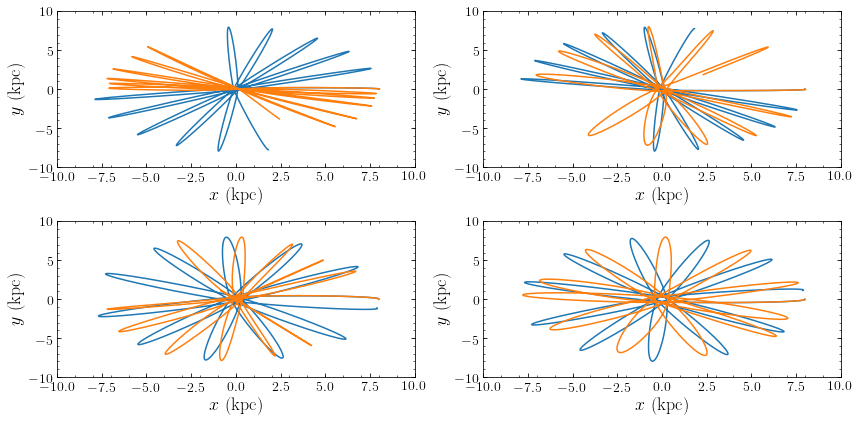

In [7]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(12,6)
subplot(2,2,1)
o= Orbit([1.,0.1,0.03,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparisonXY(o)
subplot(2,2,2)
o= Orbit([1.,0.1,-0.03,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparisonXY(o)
subplot(2,2,3)
o= Orbit([1.,0.05,0.07,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparisonXY(o)
subplot(2,2,4)
o= Orbit([1.,0.05,-0.07,0.,0.1,0.],ro=ro,vo=vo)
plot_orbit_comparisonXY(o)
tight_layout()

In [8]:
#setup Pal 5 smooth stream, only the trailing arm at the moment
sdf_trailing= pal5_util.setup_pal5model()

#Sample N points from the smooth model today 
N=1000
R,vR,vT,z,vz,phi,dt= sdf_trailing.sample(n=N,returndt=True)
#l,b,d,vlos,pmll,pmbb = sdf_smooth.sample(n=N,lb=True)

trackRADec_trailing=bovy_coords.lb_to_radec(sdf_trailing._interpolatedObsTrackLB[:,0],
                          sdf_trailing._interpolatedObsTrackLB[:,1],
                          degree=True)

#lb_sample_trailing= sdf_trailing.sample(n=10000,lb=True)
#radec_sample_trailing= bovy_coords.lb_to_radec(lb_sample_trailing[0],
#                                               lb_sample_trailing[1],
#                                               degree=True)


l_unp=numpy.empty(N)
b_unp=numpy.empty(N)

for i in range(N):
    l_unp[i]=galcencyl_to_lbd(R[i],phi[i],z[i])[0]
    b_unp[i]=galcencyl_to_lbd(R[i],phi[i],z[i])[1]
    
radec1=bovy_coords.lb_to_radec(l_unp,b_unp,degree=True)  

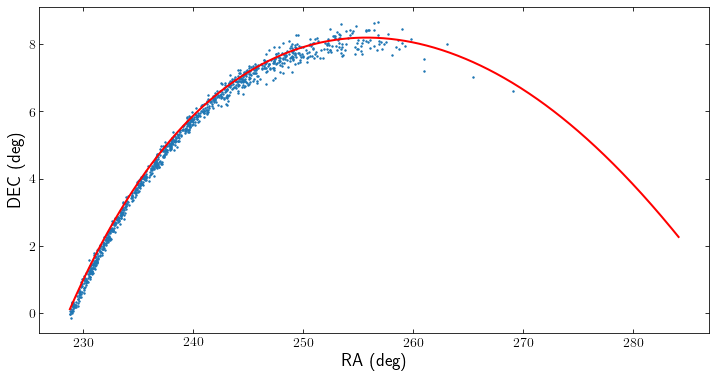

In [9]:
#plot unperturbed stream 


plt.figure()
plt.scatter(radec1[:,0],radec1[:,1],s=2)
plt.plot(trackRADec_trailing[:,0],trackRADec_trailing[:,1],lw=2,c='r')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
plt.show()


210


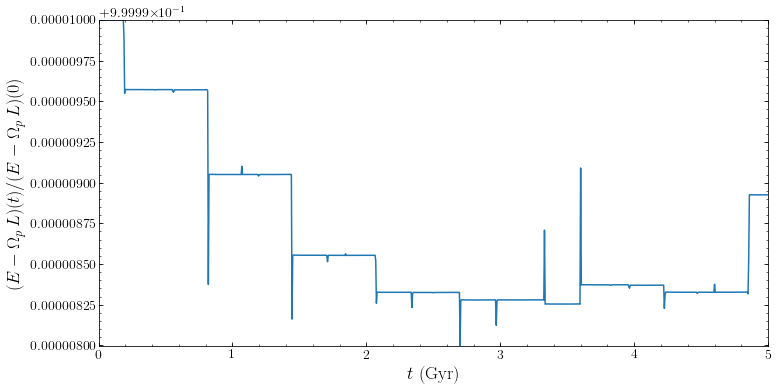

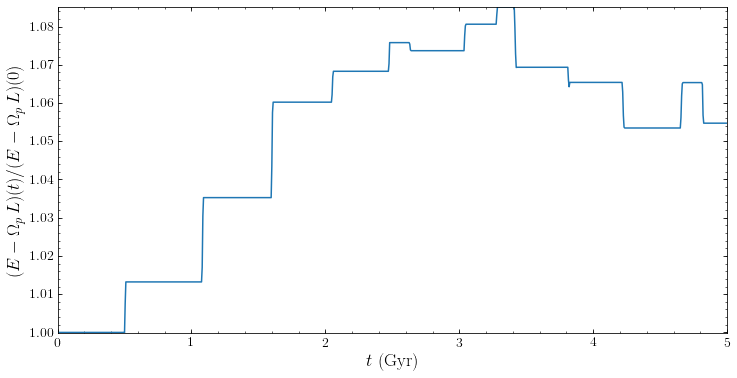

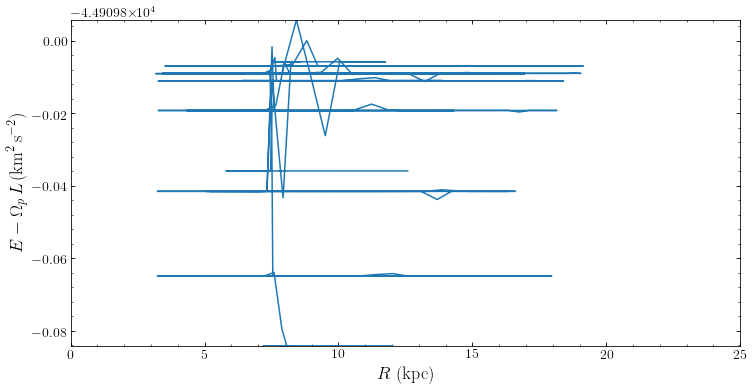

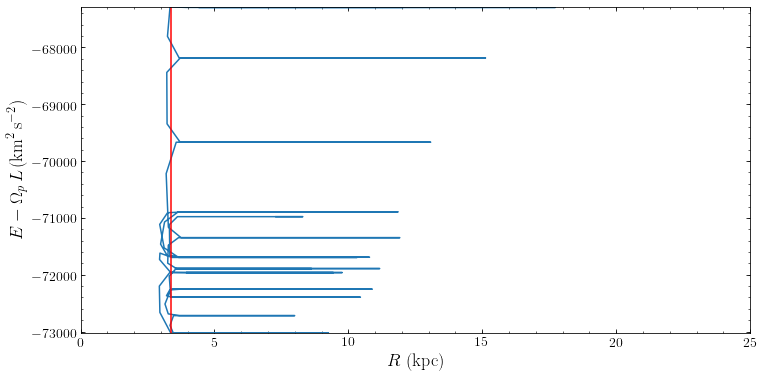

In [28]:
#plot Jacobi integral to check whether it is conserved
from random import randint
ind=randint(0,len(R)-1)
print ind

ts= numpy.linspace(0,5.0,1001)*u.Gyr
o1= Orbit([R[ind],vR[ind],vT[ind],z[ind],vz[ind],phi[ind]],ro=ro,vo=vo)
o1.integrate(ts,MWPotential2014)
o1.plotJacobi(normed=True)

obar= Orbit([R[ind],vR[ind],vT[ind],z[ind],vz[ind],phi[ind]],ro=ro,vo=vo)
obar.integrate(ts,MWPotential2014bar)
obar.plotJacobi(normed=True)

#plot Jacobi integral w.r.t the radius 

o1.plot(d1='R',d2='Jacobi',xrange=[0.,25])

obar.plot(d1='R',d2='Jacobi',xrange=[0.,25])
axvline(dp._rb*ro,c='r') # this plots the bar radius


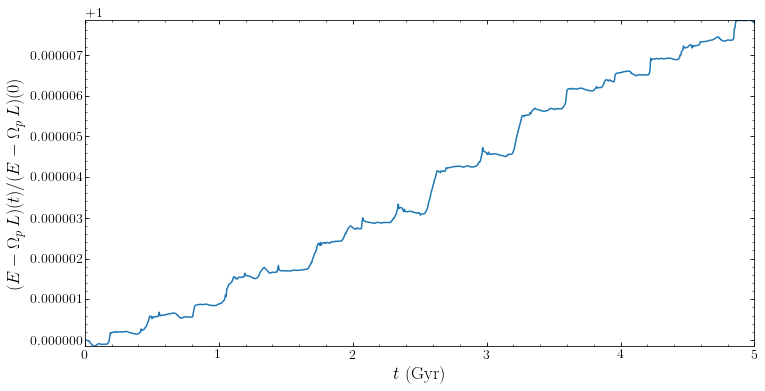

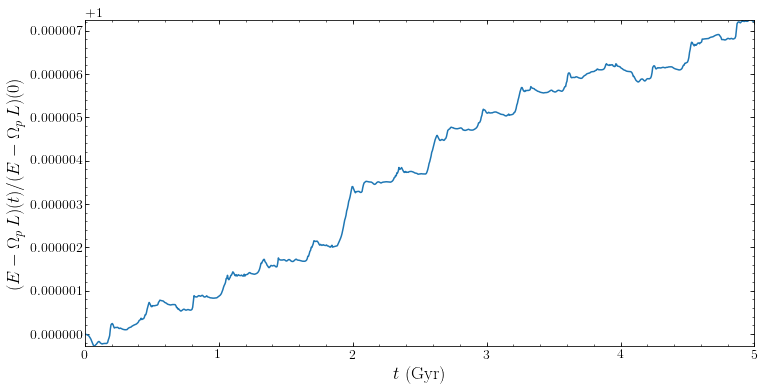

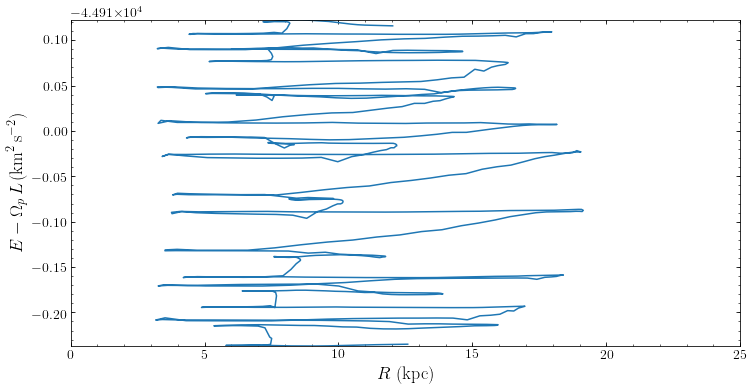

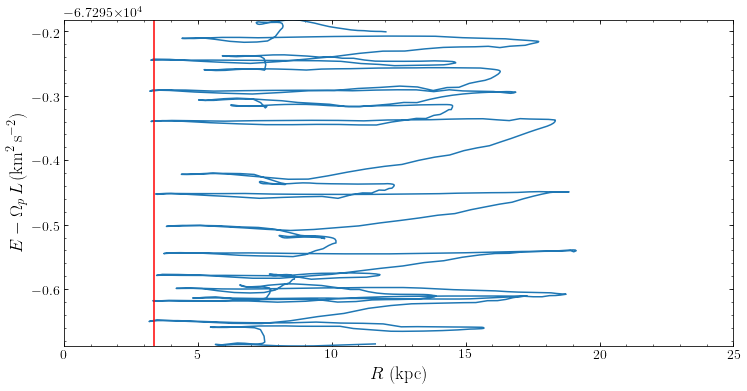

In [37]:
#Integrate using scipy's odeint
#plot Jacobi integral to check whether it is conserved
#http://galpy.readthedocs.io/en/latest/reference/orbitint.html?highlight=integrate
method='odeint'

ts= numpy.linspace(0,5.0,1001)*u.Gyr
o1= Orbit([R[ind],vR[ind],vT[ind],z[ind],vz[ind],phi[ind]],ro=ro,vo=vo)
o1.integrate(ts,MWPotential2014,method=method)
o1.plotJacobi(normed=True)

obar= Orbit([R[ind],vR[ind],vT[ind],z[ind],vz[ind],phi[ind]],ro=ro,vo=vo)
obar.integrate(ts,MWPotential2014bar,method=method)
obar.plotJacobi(normed=True)

#plot Jacobi integral w.r.t the radius 

o1.plot(d1='R',d2='Jacobi',xrange=[0.,25])

obar.plot(d1='R',d2='Jacobi',xrange=[0.,25])
axvline(dp._rb*ro,c='r') # this plots the bar radius

In [38]:
# integrate these N particles *backward* in time to when they were all stripped (they were stripped dt in the past, dt is different for each particle); something like
orbits= []
for ii in range(N):
    o= Orbit([R[ii],vR[ii],vT[ii],z[ii],vz[ii],phi[ii]]).flip() # flip flips the velocities for backwards integration
    ts= numpy.linspace(0.,dt[ii],1001)
    o.integrate(ts,MWPotential2014,method=method)
    orbits.append(o(ts[-1]).flip()) # get the orbit at the final time step, flip the velocities for forward integration below

In [ ]:
#integrate all points *forward* in time in the barred potential 
# MWPotential2014bar

finalR= numpy.empty(N)
finalphi= numpy.empty(N)
finalz= numpy.empty(N)
for ii in range(N):
    ts= numpy.linspace(0.,dt[ii],1001)
    orbits[ii].integrate(ts,MWPotential2014bar,method=method)
    finalR[ii]= orbits[ii].R(ts[-1])
    finalphi[ii]= orbits[ii].phi(ts[-1])
    finalz[ii]= orbits[ii].z(ts[-1])

In [ ]:
l_p=numpy.empty(N)
b_p=numpy.empty(N)

for i in range(N):
    l_p[i]=galcencyl_to_lbd(finalR[i],finalphi[i],finalz[i])[0]
    b_p[i]=galcencyl_to_lbd(finalR[i],finalphi[i],finalz[i])[1]
    
radec=bovy_coords.lb_to_radec(l_p,b_p,degree=True)    
    

In [ ]:
plt.figure()
plt.scatter(radec[:,0],radec[:,1],s=2)
plt.plot(trackRADec_trailing[:,0],trackRADec_trailing[:,1],lw=2,c='r',label='unperturbed')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
plt.legend(loc='upper left')
plt.savefig('Dehnenbar_effect_Pal5_rolr{}_barphi{}_intmethod{}.pdf'.format(rolr,barphi,method))
plt.show()